In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
from scipy.stats import zscore 

from snmcseq_utils import plot_tsne_labels

In [4]:
input_f = './data/cluster/cluster_MB_v1/genebody_mCH_human_combined_cluster_MB_v1_mcc.tsv'
input_f2 = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/genebody_mCH_clusters_v1_mcc.tsv'

input_tsne = './data/tsne/tsne_perp30_binc_mCH_human_combined_100000_summary_nmcc_v2.tsv'
input_meta = './data/metadata/metadata_human_combined_updated.tsv'
input_cluster = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_v1_binc_mCH_louvain.tsv'

output_f2 = './data/cluster/cluster_MB_v1_MB_EA_MB_EB/clusters_v1_binc_mCH_louvain_annotation.tsv'

input_gt = './data/cluster/cluster_MB_v1/cluster_MB_v1.tsv'

# input_browser = './data/browser/human_MB_v1_MB_EA1/tsne_points_ordered.csv'
# output_browser = './data/browser/human_MB_v1_MB_EA1/tsne_points_ordered_v2.csv'

df = pd.read_table(input_f, index_col='id')
df2 = pd.read_table(input_f2, index_col='id')
df_meta = pd.read_table(input_meta, index_col='Sample')
df_cluster = pd.read_table(input_cluster)
df_tsne = pd.read_table(input_tsne)
df_gt = pd.read_table(input_gt, index_col='sample')['cell_type'].to_frame()
print(df.shape)
print(df2.shape)

(30152, 21)
(28744, 32)


In [5]:
df_cmb = pd.merge(df, df2, left_index=True, right_index=True)
print(df_cmb.shape)

(28570, 53)


In [6]:
def reorder_cols(cols):
    cols_ordered = sorted([int(col.split('_')[1]) for col in cols])
    cols_ordered = ['cluster_'+str(col)+'_mcc' for col in cols_ordered]
    return cols_ordered

celltype_cols = df.filter(regex='_mcc$').columns.values 
cluster_cols = reorder_cols(df2.filter(regex='_mcc$').columns.values) 
celltypes = [col[:-len('_mcc')] for col in celltype_cols]
clusters = [col[:-len('_mcc')] for col in cluster_cols]
print(celltypes)
print(clusters)

['hDL-1', 'hDL-2', 'hDL-3', 'hL2/3', 'hL4', 'hL5-1', 'hL5-2', 'hL5-3', 'hL5-4', 'hL6-1', 'hL6-2', 'hL6-3', 'hNdnf', 'hNos', 'hPv-1', 'hPv-2', 'hSst-1', 'hSst-2', 'hSst-3', 'hVip-1', 'hVip-2']
['cluster_1', 'cluster_2', 'cluster_3', 'cluster_4', 'cluster_5', 'cluster_6', 'cluster_7', 'cluster_8', 'cluster_9', 'cluster_10', 'cluster_11', 'cluster_12', 'cluster_13', 'cluster_14', 'cluster_15', 'cluster_16', 'cluster_17', 'cluster_18', 'cluster_19', 'cluster_20', 'cluster_21', 'cluster_22', 'cluster_23', 'cluster_24', 'cluster_25', 'cluster_26', 'cluster_27', 'cluster_28', 'cluster_29', 'cluster_30', 'cluster_31', 'cluster_32']


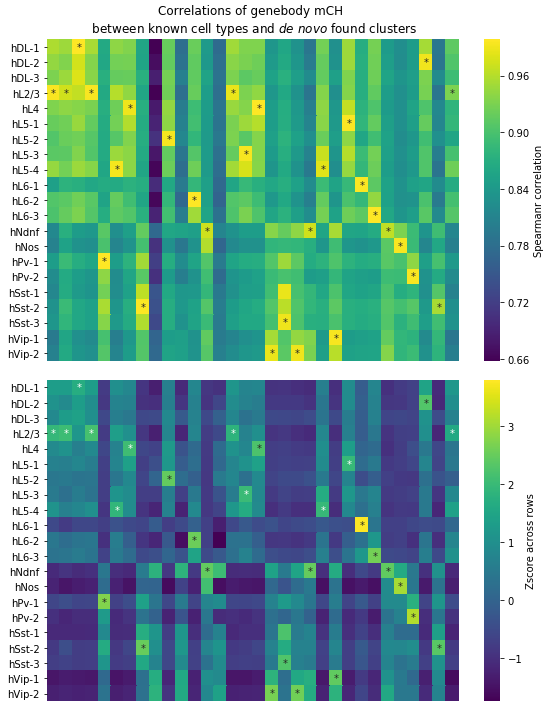

In [7]:
# do spearman correlation cell_type * clusters

rho, pval = spearmanr(df_cmb[celltype_cols], df_cmb[cluster_cols])
corr = rho[:len(celltype_cols), len(celltype_cols):]
df_corr = pd.DataFrame(corr, columns=clusters, index=celltypes)
df_corr_zscore = df_corr.apply(zscore, axis=0)

df_annot = pd.DataFrame(columns=df_corr.columns, index=df_corr.index)
celltype_res = []
for col, idx in df_corr.idxmax().iteritems():
    if df_corr.loc[idx, col] > 0.9:
        # print(col + ' --> ' + idx)
        celltype_res.append({'cluster_ID': col,
                             'cluster_annotation': idx})
        df_annot.loc[idx, col] = '*'
    else:
        # print(col + ' cell type not matched!')
        celltype_res.append({'cluster_ID': col,
                             'cluster_annotation': np.nan})
        
celltype_res = pd.DataFrame(celltype_res)
df_annot = df_annot.fillna('')
    
fig, axs = plt.subplots(2, 1, figsize=(8, 10))
ax = axs[0]
sns.heatmap(df_corr, 
        ax=ax,
        cmap='viridis',
        annot = df_annot, fmt='',
        # linewidth = 0.01,
        xticklabels = False,
        cbar_kws={'label':'Spearmanr correlation'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
ax.set_title('Correlations of genebody mCH \n between known cell types and $de$ $novo$ found clusters')

ax = axs[1]
sns.heatmap(df_corr_zscore, 
        ax=ax,
        cmap='viridis',
        annot = df_annot, fmt='',
        # linewidth = 0.01,
        xticklabels = False,
        cbar_kws={'label':'Zscore across rows'})
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
# ax.set_title('')
fig.tight_layout()
plt.show()




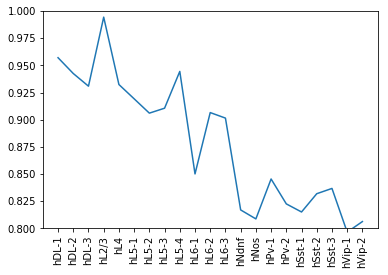

In [8]:
fig, ax = plt.subplots()
ax.plot(df_corr['cluster_1'].values)
ax.set_xticks([i for i in range(len(celltypes))])
ax.set_xticklabels(celltypes, rotation=90)
ax.set_ylim([0.8, 1])
plt.show()

In [9]:
print(celltype_res.head())
celltype_res.to_csv(output_f2, sep='\t', na_rep='NA', index=False, header=True)

  cluster_ID cluster_annotation
0  cluster_1              hL2/3
1  cluster_2              hL2/3
2  cluster_3              hDL-1
3  cluster_4              hL2/3
4  cluster_5              hPv-1


(6435, 5)
Saved to ./results/tsne_clusters/tsne_cluster_MB_v1_MB_EA_MB_EB_cluster_v1_annotation.pdf


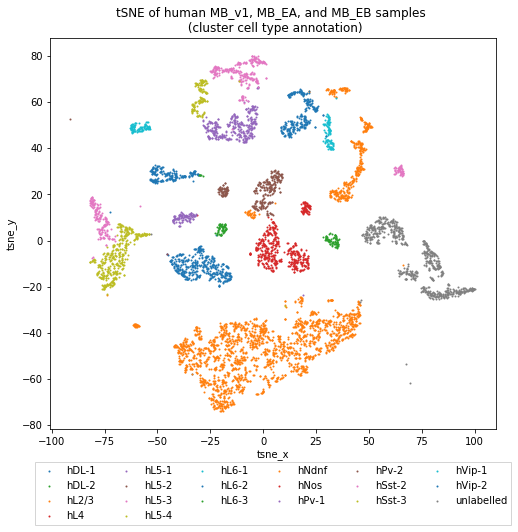

In [11]:
# tSNE plot as confirmation

# new result
df_celltype = pd.merge(celltype_res, df_cluster, left_on='cluster_ID', right_on='cluster_ID')
df_plot = pd.merge(df_tsne, df_celltype, left_on='sample', right_on='sample')
print(df_plot.shape)

plot_tsne_labels(df_plot, tc='cluster_annotation', 
    title='tSNE of human MB_v1, MB_EA, and MB_EB samples \n (cluster cell type annotation)', 
    figsize=(8,8), legend_mode=1,
    output='./results/tsne_clusters/tsne_cluster_MB_v1_MB_EA_MB_EB_cluster_v1_annotation.pdf'
    )



(6435, 4)
Saved to ./results/tsne_clusters/tsne_cluster_MB_v1_MB_EA_MB_EB_cluster_v1_annotation_gt.pdf


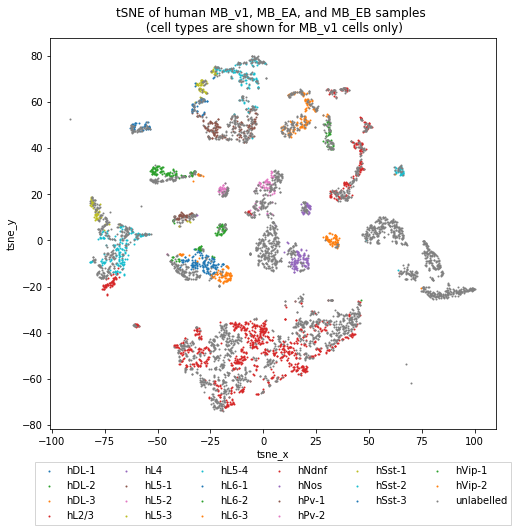

In [13]:
# new result
df_plot = pd.merge(df_tsne, df_gt, left_on='sample', right_index=True, how='left')
print(df_plot.shape)

plot_tsne_labels(df_plot, tc='cell_type', 
    title='tSNE of human MB_v1, MB_EA, and MB_EB samples \n (cell types are shown for MB_v1 cells only)', 
    figsize=(8,8), legend_mode=1,
    output='./results/tsne_clusters/tsne_cluster_MB_v1_MB_EA_MB_EB_cluster_v1_annotation_gt.pdf'
    )

# old result


# more unlabelled cells